In [1]:
#pip install googletrans
#!pip install translate
#!pip install mtranslate

# 1. Importing Necessary Liabraries

In [2]:
import pandas as pd
import numpy as np
from translate import Translator
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import re
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from bs4 import BeautifulSoup
import re
from unidecode import unidecode
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder


In [3]:
df= pd.read_csv(r"C:\Users\sandi\Desktop\RAM MANDIR\RamMandir_Reviews.csv",encoding='latin-1')

In [4]:
df.head()

,Author,Time_,Comments
0,Yash Nipane,2 months ago on,The Ram Mandir seems to have been awe-inspirin...
1,priyanka yedallou,a month ago on,This is very newly created beautiful Ram templ...
2,Pranay Bante,a month ago on,"A must-visit in Nagpur, the Koradi temple is a..."
3,Khushi,4 months ago on,Beautiful Ram Temple(30 Rs/- each entry ) with...
4,Ghoshal,3 weeks ago on,Beautiful place.Pictures will look amazing.Tic...


In [5]:
df.shape

(8457, 3)

# 2. Data Preprocessing:

# a. Data Cleaning:

## Renaming Columns

In [6]:
df.rename(columns = {'Author':'person_name','Time_':'Time'},
                     inplace=True)

In [7]:
df

,person_name,Time,Comments
0,Yash Nipane,2 months ago on,The Ram Mandir seems to have been awe-inspirin...
1,priyanka yedallou,a month ago on,This is very newly created beautiful Ram templ...
2,Pranay Bante,a month ago on,"A must-visit in Nagpur, the Koradi temple is a..."
3,Khushi,4 months ago on,Beautiful Ram Temple(30 Rs/- each entry ) with...
4,Ghoshal,3 weeks ago on,Beautiful place.Pictures will look amazing.Tic...
...,...,...,...
8452,@shonapramanick7725,13 minutes ago,"Mandir and Masjid co-exist in India, this is t..."
8453,@abhijeetkishore1412,14 minutes ago,Jai shree ram
8454,@bhaskerksingh9081,14 minutes ago,proud moment for all
8455,@creativeexplorer2741,14 minutes ago,Jai shree Ram Jai Jai Bharat


In [8]:
df.head(2)

,person_name,Time,Comments
0,Yash Nipane,2 months ago on,The Ram Mandir seems to have been awe-inspirin...
1,priyanka yedallou,a month ago on,This is very newly created beautiful Ram templ...


# Handling missing values if any.

In [9]:
df.isnull().sum()

person_name    17
Time            1
Comments       33
dtype: int64

In [10]:
df=df.dropna()

In [11]:
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

In [12]:
df.shape

(8413, 3)

# b. Text Cleaning:

## 1.Remove special characters, numbers, and punctuation and emojee 

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sandi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sandi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sandi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [14]:
df = pd.DataFrame(df)

## 2.Removing Stopwords

In [15]:
# Function to clean text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, numbers, punctuation, and emojis
    text = re.sub(r'[^A-Za-z\s]', '', text.encode('ascii', 'ignore').decode('ascii'))
   
    # Remove stop words, including custom words like 'no' and 'not'
    stop_words = set(stopwords.words('english'))
    custom_stop_words = ["not","wouldn't","don't","didn't","aren't","doesn't","hasn't","won't","haven't","hadn't","mightn't","wasn't","isn't","needn't","shouldn't","weren't","couldn't"]
    stop_words.update(custom_stop_words)
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    return ' '.join(lemmatized_words)
   

# Apply the cleaning function to the 'Comments' column
df['Comments'] = df['Comments'].apply(clean_text)

# Display only 'person_name', 'Time', and 'Comments' columns
print(df[['person_name', 'Time', 'Comments']])

                person_name             Time  \
0               Yash Nipane  2 months ago on   
1         priyanka yedallou   a month ago on   
2              Pranay Bante   a month ago on   
3                    Khushi  4 months ago on   
4                   Ghoshal   3 weeks ago on   
...                     ...              ...   
8452    @shonapramanick7725   13 minutes ago   
8453   @abhijeetkishore1412   14 minutes ago   
8454     @bhaskerksingh9081   14 minutes ago   
8455  @creativeexplorer2741   14 minutes ago   
8456       @maniaphobia4719   14 minutes ago   

                                               Comments  
0     ram mandir seems aweinspiring grandeur intrica...  
1     newly created beautiful ram temple tell whole ...  
2     mustvisit nagpur koradi temple hidden gem offe...  
3     beautiful ram temple r entry mainly attraction...  
4     beautiful placepictures look amazingtickets pr...  
...                                                 ...  
8452  mandir masj

## 3. Language Labeling:

In [16]:
import langid

def detect_language(text):
    lang, _ = langid.classify(text)
    return lang

# Apply language detection  DataFrame
df['Language'] = df['Comments'].apply(detect_language)

In [17]:
df

,person_name,Time,Comments,Language
0,Yash Nipane,2 months ago on,ram mandir seems aweinspiring grandeur intrica...,en
1,priyanka yedallou,a month ago on,newly created beautiful ram temple tell whole ...,en
2,Pranay Bante,a month ago on,mustvisit nagpur koradi temple hidden gem offe...,de
3,Khushi,4 months ago on,beautiful ram temple r entry mainly attraction...,en
4,Ghoshal,3 weeks ago on,beautiful placepictures look amazingtickets pr...,en
...,...,...,...,...
8452,@shonapramanick7725,13 minutes ago,mandir masjid coexist india essence indiaexplo...,pt
8453,@abhijeetkishore1412,14 minutes ago,jai shree ram,en
8454,@bhaskerksingh9081,14 minutes ago,proud moment,nl
8455,@creativeexplorer2741,14 minutes ago,jai shree ram jai jai bharat,lt


## 4.Translation

In [18]:
# Function to translate text to English
def translate_to_english(text):
    if pd.isnull(text):
        return text
    translator = Translator(to_lang='en')
    translation = translator.translate(text)
    return translation

# Assuming  DataFrame is 
for index, row in df.iterrows():
    comment = row['Comments']
    language = row['Language']

    if language != 'en' and not pd.isnull(comment):
        translated_comment = translate_to_english(comment)
        df.at[index, 'Comments'] = translated_comment
        df.at[index, 'Language'] = 'en'  # Update the language label to 'en'

# Save the updated DataFrame to a new CSV file
df.to_csv(r'C:\Users\sandi\Desktop\RAM MANDIR\updated.csv', index=False)

In [19]:
ram=pd.read_csv(r'C:\Users\sandi\Desktop\RAM MANDIR\updated.csv')

In [20]:
ram.head()

,person_name,Time,Comments,Language
0,Yash Nipane,2 months ago on,ram mandir seems aweinspiring grandeur intrica...,en
1,priyanka yedallou,a month ago on,newly created beautiful ram temple tell whole ...,en
2,Pranay Bante,a month ago on,mustvisit nagpur koradi temple hidden gem offe...,en
3,Khushi,4 months ago on,beautiful ram temple r entry mainly attraction...,en
4,Ghoshal,3 weeks ago on,beautiful placepictures look amazingtickets pr...,en


In [21]:
ram.isnull().sum()[ram.isnull().sum()>0]

Comments    844
dtype: int64

In [22]:
ram=ram.dropna()

In [23]:
ram.shape

(7569, 4)

# 3. Exploratory Data Analysis (EDA)

# a. Word Cloud:
Creating a word cloud to visualize the most frequent words in the reviews.

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [25]:
# Combine all comments into a single string for word cloud generation
all_comments = ' '.join(df['Comments'].dropna())


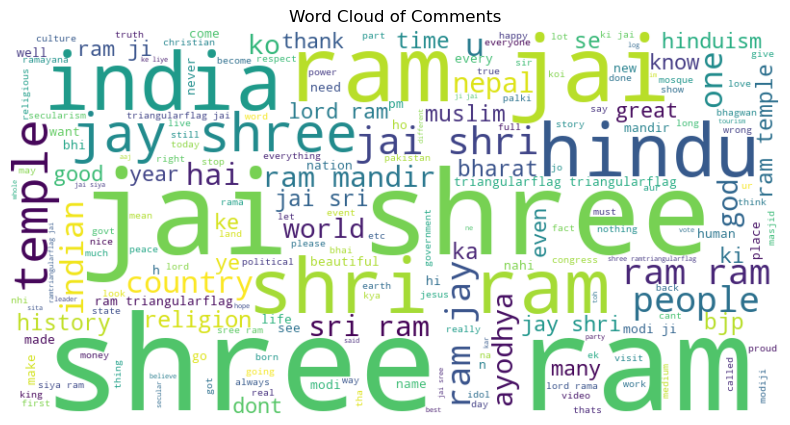

In [26]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()

# b.Sentiment Analysis:
Comments  into categories like positive, negative, or neutral.

In [27]:
from textblob import TextBlob

In [28]:
ram['Comments'] = ram['Comments'].apply(clean_text)

# Perform sentiment analysis using TextBlob
def analyze_sentiment(text):
    analysis = TextBlob(text)
    # Classify the polarity as positive, negative, or neutral
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [29]:
# Apply sentiment analysis to the 'Comments' column
ram['Sentiment'] = ram['Comments'].apply(analyze_sentiment)

# Display the DataFrame with sentiment analysis results
print(ram[['person_name', 'Time', 'Comments', 'Sentiment']])

                person_name             Time  \
0               Yash Nipane  2 months ago on   
1         priyanka yedallou   a month ago on   
2              Pranay Bante   a month ago on   
3                    Khushi  4 months ago on   
4                   Ghoshal   3 weeks ago on   
...                     ...              ...   
8408    @shonapramanick7725   13 minutes ago   
8409   @abhijeetkishore1412   14 minutes ago   
8410     @bhaskerksingh9081   14 minutes ago   
8411  @creativeexplorer2741   14 minutes ago   
8412       @maniaphobia4719   14 minutes ago   

                                               Comments Sentiment  
0     ram mandir seems aweinspiring grandeur intrica...  Positive  
1     newly created beautiful ram temple tell whole ...  Positive  
2     mustvisit nagpur koradi temple hidden gem offe...  Positive  
3     beautiful ram temple r entry mainly attraction...  Positive  
4     beautiful placepictures look amazingtickets pr...  Positive  
...            

In [30]:
ram.head()

,person_name,Time,Comments,Language,Sentiment
0,Yash Nipane,2 months ago on,ram mandir seems aweinspiring grandeur intrica...,en,Positive
1,priyanka yedallou,a month ago on,newly created beautiful ram temple tell whole ...,en,Positive
2,Pranay Bante,a month ago on,mustvisit nagpur koradi temple hidden gem offe...,en,Positive
3,Khushi,4 months ago on,beautiful ram temple r entry mainly attraction...,en,Positive
4,Ghoshal,3 weeks ago on,beautiful placepictures look amazingtickets pr...,en,Positive


In [31]:
# Assuming 'ram' DataFrame containing the data
negative_comments = ram[ram['Sentiment'] == 'Negative']['Comments'].str.cat(sep=' ')
neutral_comments = ram[ram['Sentiment'] == 'Neutral']['Comments'].str.cat(sep=' ')
positive_comments = ram[ram['Sentiment'] == 'Positive']['Comments'].str.cat(sep=' ')

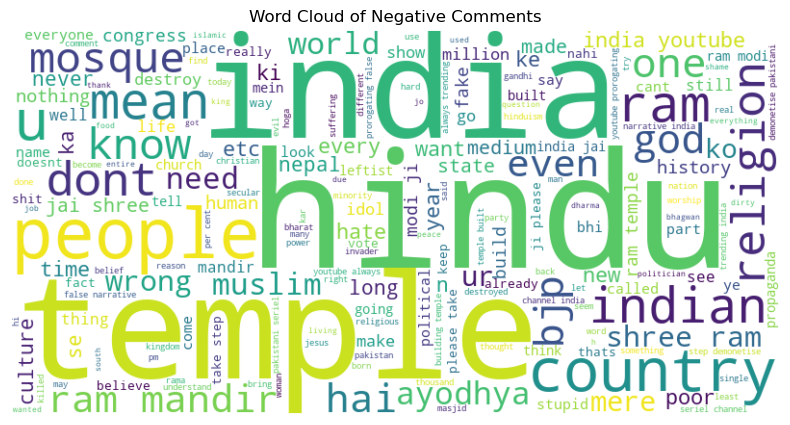

In [32]:
# Create WordCloud for Negative Comments
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_comments)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Comments')
plt.show()


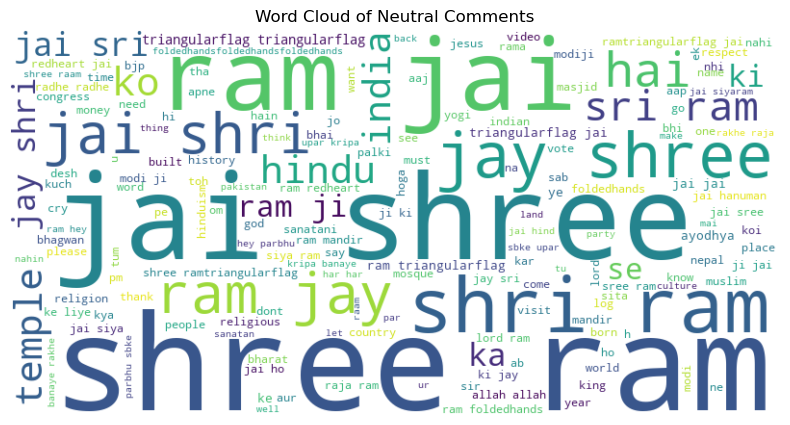

In [33]:
# Create WordCloud for Neutral Comments
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_comments)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Neutral Comments')
plt.show()


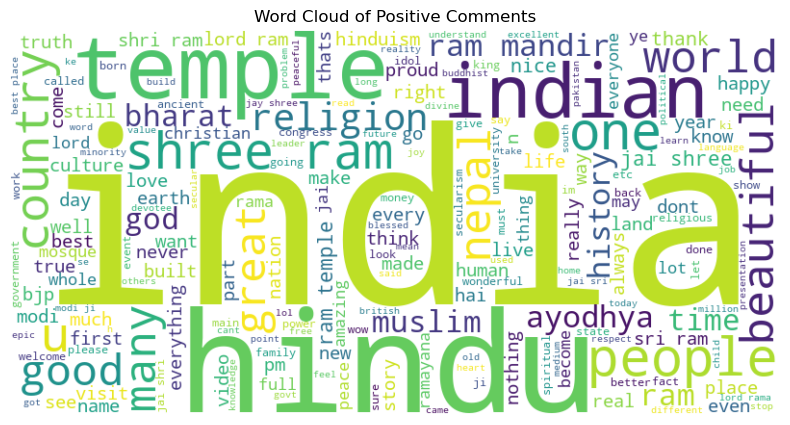

In [34]:
# Create WordCloud for Positive Comments
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_comments)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Comments')
plt.show()

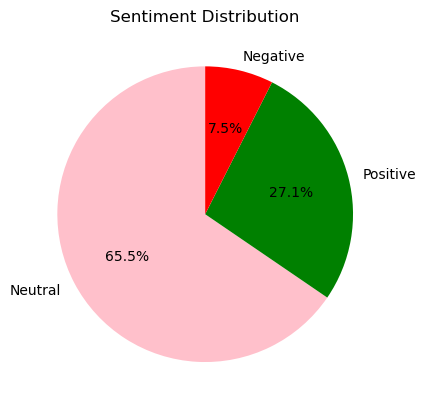

In [35]:
sentiment_counts = ram['Sentiment'].value_counts()

# Plotting a pie chart
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['pink', 'green', 'red'])
plt.title('Sentiment Distribution')
plt.show()

# 4.Spliting Data into Train And Test

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(ram['Comments'], ram['Sentiment'], test_size=0.2, random_state=42)


# 5. Feature Extraction:


## a. TF-IDF Vectorization:
Convert the text data into numerical format using TF-IDF vectorization.

In [37]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 6. Model Building:

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# 7.Model Evaluation

## 1.Logistic regression Model

In [39]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()

In [40]:

classifier.fit(X_train_tfidf, y_train)

LogisticRegression()

In [41]:
y_pred = classifier.predict(X_test_tfidf)

In [42]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [43]:
accuracy

0.8698811096433289

In [44]:
print(classification_rep)

              precision    recall  f1-score   support

    Negative       0.88      0.21      0.33       112
     Neutral       0.86      0.98      0.92       969
    Positive       0.89      0.79      0.84       433

    accuracy                           0.87      1514
   macro avg       0.88      0.66      0.70      1514
weighted avg       0.87      0.87      0.85      1514



## class imbalance is seen in this data 

## using Random Over Smapler for class imbalance problem

In [45]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)



In [46]:
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_resampled, y_resampled)
best_lr_classifier = grid_search_lr.best_estimator_

In [47]:
# Step 3: Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_resampled, y_resampled)


RandomForestClassifier(random_state=42)

In [48]:
# Step 4: Support Vector Machine (SVM)
svm_classifier = SVC(C=1, kernel='linear', class_weight='balanced', random_state=42)
svm_classifier.fit(X_resampled, y_resampled)


SVC(C=1, class_weight='balanced', kernel='linear', random_state=42)

In [49]:
# Step 5: Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_resampled, y_resampled)

MultinomialNB()

In [50]:
# Step 6: k-Nearest Neighbors (k-NN)
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_resampled, y_resampled)


KNeighborsClassifier()

In [51]:
# Step 7: AdaBoost
dt_base_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
adaboost_classifier = AdaBoostClassifier(base_estimator=dt_base_classifier, n_estimators=50, random_state=42)
adaboost_classifier.fit(X_resampled, y_resampled)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=42),
                   random_state=42)

In [52]:
# Step 8: Gradient Boosting
gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gradient_boosting_classifier.fit(X_resampled, y_resampled)

GradientBoostingClassifier(random_state=42)

In [53]:
classifiers = {
    'Logistic Regression': best_lr_classifier,
    'Random Forest': rf_classifier,
    'SVM': svm_classifier,
    'Naive Bayes': nb_classifier,
    'k-NN': knn_classifier,
    'AdaBoost': adaboost_classifier,
    'Gradient Boosting': gradient_boosting_classifier
}


In [54]:
for classifier_name, classifier in classifiers.items():
    print(f"\n{classifier_name}:")
    
    # Evaluate the model
    y_pred = classifier.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    
    # Print the results
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_rep)


Logistic Regression:
Accuracy: 0.9062087186261559
Classification Report:
               precision    recall  f1-score   support

    Negative       0.69      0.56      0.62       112
     Neutral       0.93      0.96      0.95       969
    Positive       0.89      0.88      0.88       433

    accuracy                           0.91      1514
   macro avg       0.84      0.80      0.82      1514
weighted avg       0.90      0.91      0.90      1514


Random Forest:
Accuracy: 0.8982826948480845
Classification Report:
               precision    recall  f1-score   support

    Negative       0.85      0.39      0.54       112
     Neutral       0.90      0.98      0.94       969
    Positive       0.90      0.84      0.86       433

    accuracy                           0.90      1514
   macro avg       0.88      0.74      0.78      1514
weighted avg       0.90      0.90      0.89      1514


SVM:
Accuracy: 0.9055482166446499
Classification Report:
               precision    recall  

# Hyper Parameter Tunning

## Random Forest

In [55]:
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_tfidf, y_train)
best_rf_classifier = grid_search_rf.best_estimator_

## SVM:



In [56]:

param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train_tfidf, y_train)
best_svm_classifier = grid_search_svm.best_estimator_

# k-NN:


In [57]:

param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train_tfidf, y_train)
best_knn_classifier = grid_search_knn.best_estimator_

## AdaBoost:

In [58]:
param_grid_adaboost = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}
grid_search_adaboost = GridSearchCV(AdaBoostClassifier(), param_grid_adaboost, cv=5, scoring='accuracy')
grid_search_adaboost.fit(X_train_tfidf, y_train)
best_adaboost_classifier = grid_search_adaboost.best_estimator_

## Gradient Boosting:

In [59]:
param_grid_gb = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]}
grid_search_gb = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, cv=5, scoring='accuracy')
grid_search_gb.fit(X_train_tfidf, y_train)
best_gb_classifier = grid_search_gb.best_estimator_

In [60]:
classifiers = {
    'Logistic Regression': best_lr_classifier,
    'Random Forest': best_rf_classifier,
    'SVM': best_svm_classifier,
    'Naive Bayes': nb_classifier,
    'k-NN': best_knn_classifier,
    'AdaBoost': best_adaboost_classifier,
    'Gradient Boosting': best_gb_classifier
}


# Model Evalution

In [61]:
for classifier_name, classifier in classifiers.items():
    print(f"\n{classifier_name}:")
    
    # Evaluate the model
    y_pred = classifier.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    
    # Print the results
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_rep)


Logistic Regression:
Accuracy: 0.9062087186261559
Classification Report:
               precision    recall  f1-score   support

    Negative       0.69      0.56      0.62       112
     Neutral       0.93      0.96      0.95       969
    Positive       0.89      0.88      0.88       433

    accuracy                           0.91      1514
   macro avg       0.84      0.80      0.82      1514
weighted avg       0.90      0.91      0.90      1514


Random Forest:
Accuracy: 0.8982826948480845
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.33      0.49       112
     Neutral       0.89      1.00      0.94       969
    Positive       0.92      0.82      0.87       433

    accuracy                           0.90      1514
   macro avg       0.91      0.72      0.77      1514
weighted avg       0.90      0.90      0.89      1514


SVM:
Accuracy: 0.9114927344782034
Classification Report:
               precision    recall  

## SVM  and Gradient Boosting model seems to have the highest accuracy.

### Saving Model

In [62]:
import pickle

pickle.dump(best_lr_classifier, open(r"C:\Users\sandi\Desktop\Cloud\build.pkl",'wb')) 
pickle.dump(best_rf_classifier, open(r"C:\Users\sandi\Desktop\Cloud\build1.pkl",'wb')) 
pickle.dump(best_svm_classifier, open(r"C:\Users\sandi\Desktop\Cloud\build2.pkl",'wb')) 
pickle.dump(nb_classifier, open(r"C:\Users\sandi\Desktop\Cloud\build3.pkl",'wb')) 
pickle.dump(best_knn_classifier, open(r"C:\Users\sandi\Desktop\Cloud\build4.pkl",'wb')) 
pickle.dump(best_adaboost_classifier, open(r"C:\Users\sandi\Desktop\Cloud\build5.pkl",'wb')) 
pickle.dump(best_gb_classifier, open(r"C:\Users\sandi\Desktop\Cloud\build6.pkl",'wb')) 

